# Drug Review Analysis

### Import needed libraries

In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scattertext as st
import spacy
from time import time
from pprint import pprint

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import gensim.downloader as api

import pyLDAvis
import pyLDAvis.sklearn

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Import dataset.

In [2]:
train = pd.read_csv('drugsComTrain_raw.tsv',sep='\t')
test = pd.read_csv('drugsComTest_raw.tsv', sep='\t')

train.head(5)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


### Convert the column of rating to a new columns of ratings_binary:
- If rating > 5, then ratings_binary = 1.
- If rating <= 5, then ratings_binary = 0.

In [3]:
def ratings_convert(rating):
    if (rating > 5):
        return 1
    else:
        return 0

In [4]:
train['rating_binary'] = train['rating'].apply(ratings_convert)
train.head(5)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,rating_binary
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,1


### Clean and preprocess the column of review:
1. Remove all special characters, punctuation using a regular expression.
2. Remove the quotation mark of " using a regular expression.
3. "&#39" is the HTML character coding for an apostrophe ('). For example "don&#39t" means "don't". Replace the "&#039" with an apostrophe of "'".
4. Remove all words containing at most two characters such as "a", "an", "in", "on", etc.
5. Remove all rows without any text left (empty text) in the column of review.

In [5]:
def clean_text(sentence):
    sentence = ' '.join(re.sub("&#039","'", sentence).split())
    sentence = ' '.join(re.sub(r'\b[!?()[].,]'," ", sentence).split())
    sentence = ' '.join(re.sub(r'\b[a-zA-Z]{1,2}\b', '', sentence).split())
    return sentence

In [6]:
train['review'] = train['review'].apply(clean_text)
train.head(5)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,rating_binary
0,206461,Valsartan,Left Ventricular Dysfunction,""" has side effect, take combination Bystolic 5...",9.0,"May 20, 2012",27,1
1,95260,Guanfacine,ADHD,""" son halfway through his fourth week Intuniv....",8.0,"April 27, 2010",192,1
2,92703,Lybrel,Birth Control,""" used take another oral contraceptive, which ...",5.0,"December 14, 2009",17,0
3,138000,Ortho Evra,Birth Control,"""This first time using any form birth control....",8.0,"November 3, 2015",10,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned life around. f...",9.0,"November 27, 2016",37,1


In [7]:
percent_missing = train.isnull().sum() * 100 / len(train)
percent_missing

Unnamed: 0       0.000000
drugName         0.000000
condition        0.557357
review           0.000000
rating           0.000000
date             0.000000
usefulCount      0.000000
rating_binary    0.000000
dtype: float64

### Extract all the tokens from the review.

In [8]:
def tokenize(sentence):
    token = word_tokenize(sentence)
    return token

In [9]:
train['tokens'] = train['review'].apply(tokenize)
train.head(5)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,rating_binary,tokens
0,206461,Valsartan,Left Ventricular Dysfunction,""" has side effect, take combination Bystolic 5...",9.0,"May 20, 2012",27,1,"[``, has, side, effect, ,, take, combination, ..."
1,95260,Guanfacine,ADHD,""" son halfway through his fourth week Intuniv....",8.0,"April 27, 2010",192,1,"[``, son, halfway, through, his, fourth, week,..."
2,92703,Lybrel,Birth Control,""" used take another oral contraceptive, which ...",5.0,"December 14, 2009",17,0,"[``, used, take, another, oral, contraceptive,..."
3,138000,Ortho Evra,Birth Control,"""This first time using any form birth control....",8.0,"November 3, 2015",10,1,"[``, This, first, time, using, any, form, birt..."
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned life around. f...",9.0,"November 27, 2016",37,1,"[``, Suboxone, has, completely, turned, life, ..."


### Replace the review column with the string only containing the lemmas of all the tokens.

In [10]:
lmtzr = WordNetLemmatizer()
train['review'] = [lmtzr.lemmatize(word) for word in train['review']]
train.head(5)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,rating_binary,tokens
0,206461,Valsartan,Left Ventricular Dysfunction,""" has side effect, take combination Bystolic 5...",9.0,"May 20, 2012",27,1,"[``, has, side, effect, ,, take, combination, ..."
1,95260,Guanfacine,ADHD,""" son halfway through his fourth week Intuniv....",8.0,"April 27, 2010",192,1,"[``, son, halfway, through, his, fourth, week,..."
2,92703,Lybrel,Birth Control,""" used take another oral contraceptive, which ...",5.0,"December 14, 2009",17,0,"[``, used, take, another, oral, contraceptive,..."
3,138000,Ortho Evra,Birth Control,"""This first time using any form birth control....",8.0,"November 3, 2015",10,1,"[``, This, first, time, using, any, form, birt..."
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned life around. f...",9.0,"November 27, 2016",37,1,"[``, Suboxone, has, completely, turned, life, ..."


### Graphically summarize the review.

In [11]:
train['rating_binary'].value_counts(normalize= True)

1    0.701867
0    0.298133
Name: rating_binary, dtype: float64

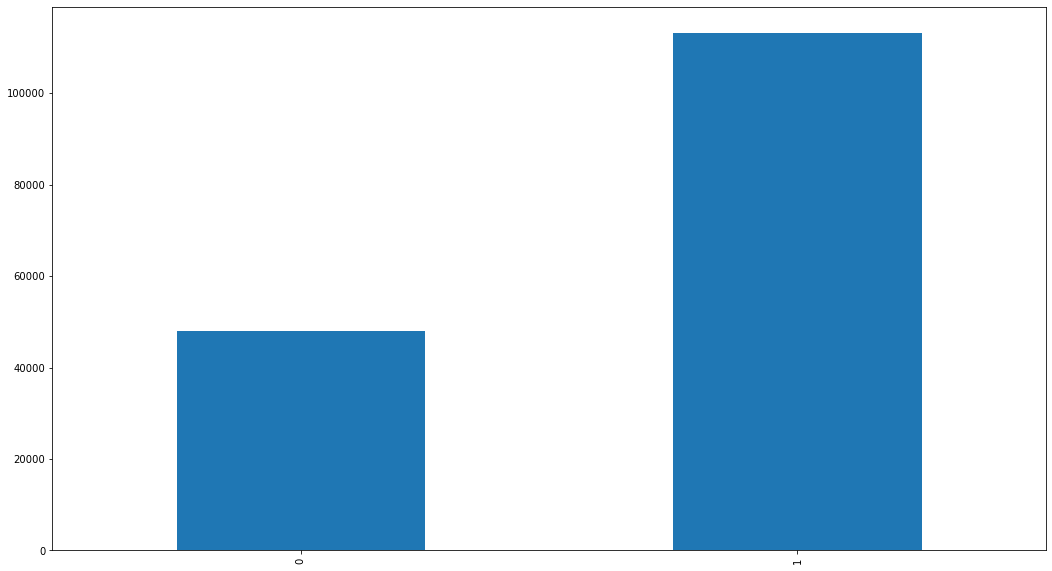

In [12]:
x = train.rating_binary.value_counts().sort_values().plot(kind = 'bar', figsize=(17.8,10))

### Graphically summarize the length of the text of the review using.

- boxplot
- histogram
- density plot

In [13]:
train["len_text"] = train["review"].str.len()
pd.options.display.float_format = "{:.2f}".format
train[["len_text"]].describe()

,len_text
count,161297.00
mean,394.66
std,208.03
min,2.00
25%,226.00
50%,391.00
75%,592.00
max,9370.00


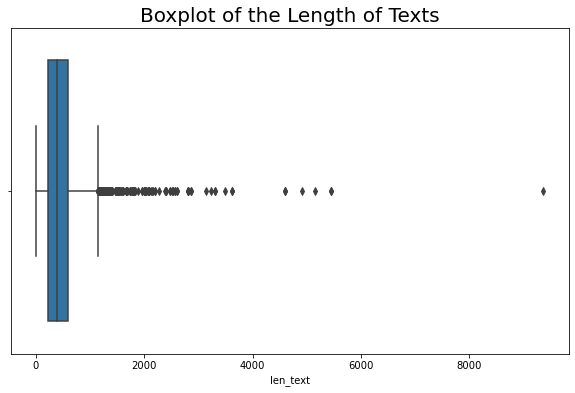

In [14]:
fig, axes = plt.subplots(1, figsize = (10, 6))
sns.boxplot(x=train["len_text"])
x = axes.set_title("Boxplot of the Length of Texts", fontsize= 20)

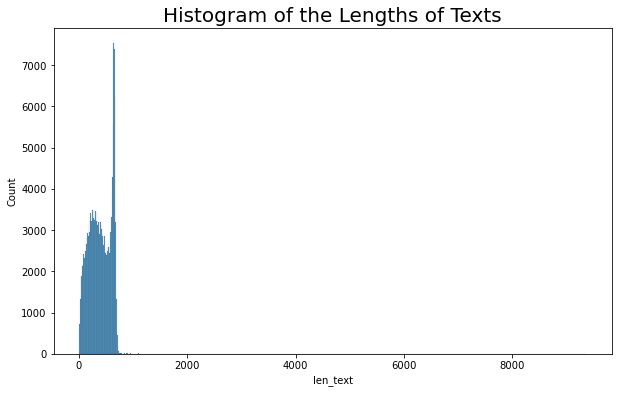

In [15]:
fig, axes = plt.subplots(1, figsize = (10, 6))
sns.histplot(data = train, x="len_text")
x= axes.set_title("Histogram of the Lengths of Texts", fontsize= 20)

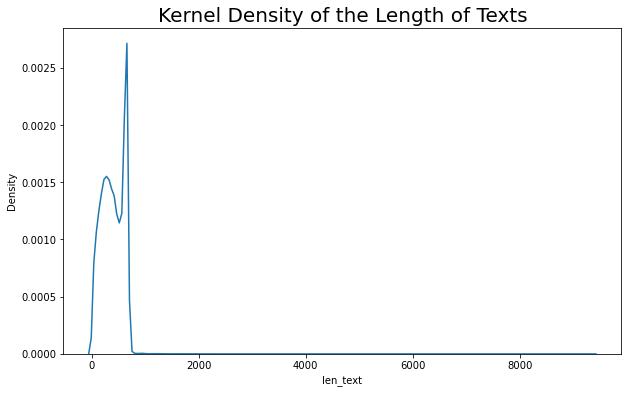

In [16]:
fig, axes = plt.subplots(1, figsize = (10, 6))
sns.kdeplot(data = train, x="len_text")
x= axes.set_title("Kernel Density of the Length of Texts", fontsize= 20)

 ### Graphically summarize the word count of the text of the review using

- boxplot
- histogram
- density plot

In [17]:
train["count_word"] = train["review"].str.split().str.len()
pd.options.display.float_format = "{:.2f}".format
train[["count_word"]].describe()

,count_word
count,161297.00
mean,65.83
std,34.57
min,1.00
25%,38.00
50%,65.00
75%,98.00
max,1500.00


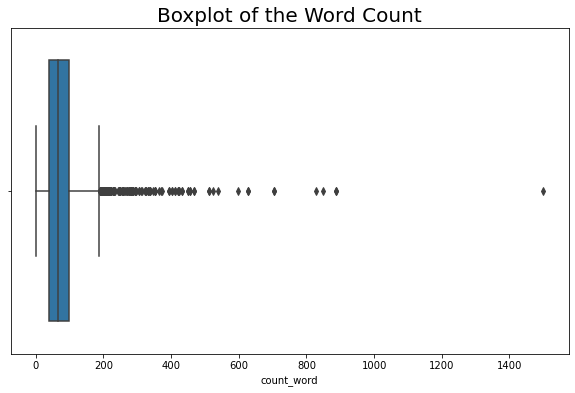

In [18]:
fig, axes = plt.subplots(1, figsize = (10, 6))
sns.boxplot(x=train["count_word"])
x = axes.set_title("Boxplot of the Word Count", fontsize= 20)

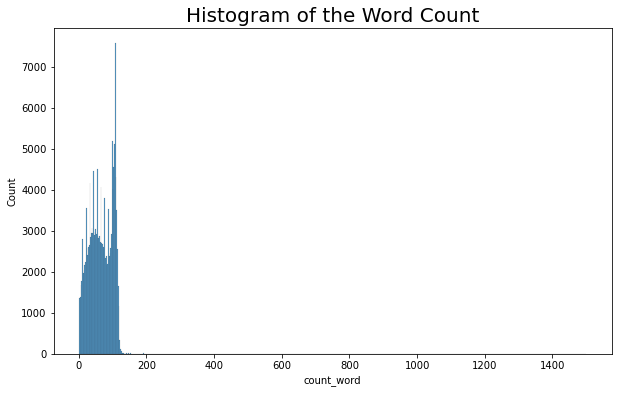

In [19]:
fig, axes = plt.subplots(1, figsize = (10, 6))
sns.histplot(data = train, x="count_word")
x= axes.set_title("Histogram of the Word Count", fontsize= 20)

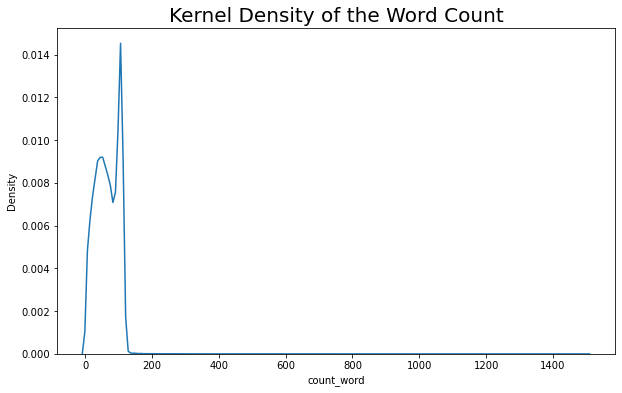

In [20]:
fig, axes = plt.subplots(1, figsize = (10, 6))
sns.kdeplot(data = train, x="count_word")
x= axes.set_title("Kernel Density of the Word Count", fontsize= 20)

### Graphically summarize the top 10 unigram and bigrams of the tf-idf of the text of the review.

In [21]:
def get_top_tf_idf_words(df = train, col = "review", use_idf = True, ngram_range =(1, 2), top_n= 5):
    
    tf_idf = TfidfVectorizer(stop_words='english', ngram_range = ngram_range, use_idf = use_idf)
    X_sparse_matrix = tf_idf.fit_transform(df[col])
    feature_names = np.array(tf_idf.get_feature_names())
    tf_idf_sparse_matrix = tf_idf.transform(df[col])
    sorted_idx = np.argsort(tf_idf_sparse_matrix.data)[:-(top_n+1):-1]

    return pd.DataFrame(
    {'feature': feature_names[tf_idf_sparse_matrix.indices[sorted_idx]],
     'tf_idf': tf_idf_sparse_matrix.data[sorted_idx],
    })

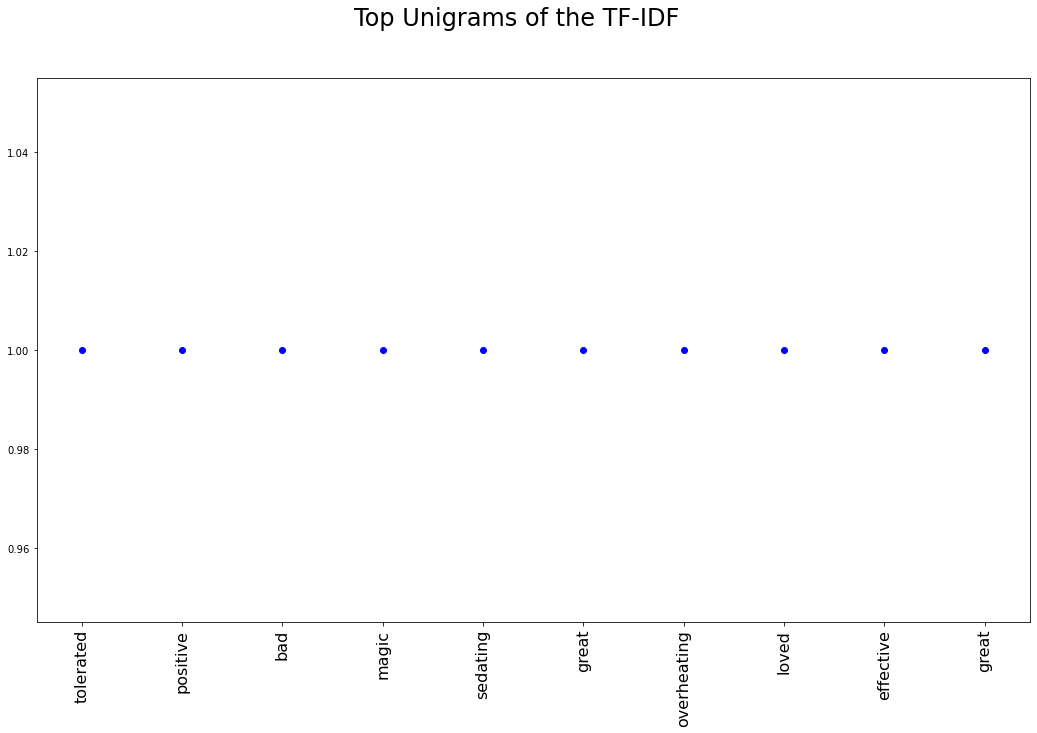

In [22]:
top_n = 10
df_text = get_top_tf_idf_words(df = train, col = "review", top_n= top_n)

x=range(0, top_n)

fig, ax = plt.subplots(1, figsize = (17.8, 10))
fig.suptitle('Top Unigrams of the TF-IDF', fontsize= 24)


ax.plot(x, df_text.tf_idf, 'bo')
ax.set_xticks(x)
x_ticks_labels = df_text.feature
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

plt.show()

In [23]:
def get_top_tf_idf_words(df = train, col = "review", use_idf = True, ngram_range =(2, 2), top_n= 5):
    
    tf_idf = TfidfVectorizer(stop_words='english', ngram_range = ngram_range, use_idf = use_idf)
    X_sparse_matrix = tf_idf.fit_transform(df[col])
    feature_names = np.array(tf_idf.get_feature_names())
    tf_idf_sparse_matrix = tf_idf.transform(df[col])
    sorted_idx = np.argsort(tf_idf_sparse_matrix.data)[:-(top_n+1):-1]

    return pd.DataFrame(
    {'feature': feature_names[tf_idf_sparse_matrix.indices[sorted_idx]],
     'tf_idf': tf_idf_sparse_matrix.data[sorted_idx],
    })

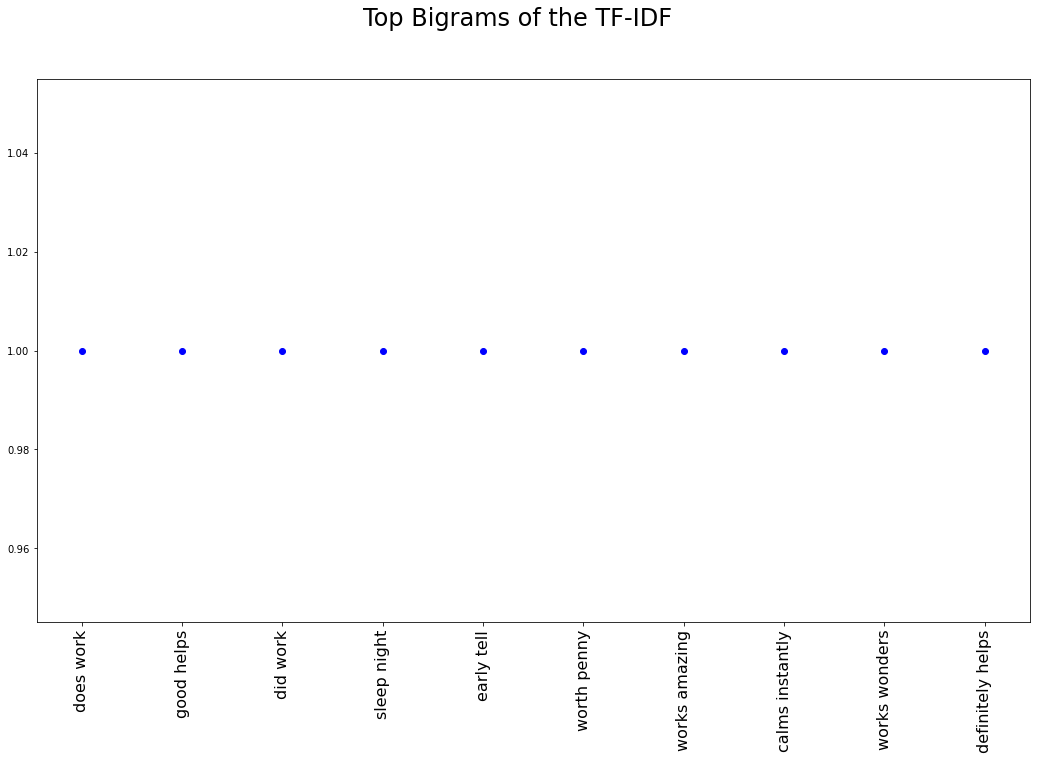

In [24]:
top_n = 10
df_text = get_top_tf_idf_words(df = train, col = "review", top_n= top_n)

x=range(0, top_n)

fig, ax = plt.subplots(1, figsize = (17.8, 10))
fig.suptitle('Top Bigrams of the TF-IDF', fontsize= 24)


ax.plot(x, df_text.tf_idf, 'bo')
ax.set_xticks(x)
x_ticks_labels = df_text.feature
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

plt.show()

### Visualize the top 10 term frequency of the tokens associated with positive review (ratings_binary = 1) using scattertext.

In [25]:
nlp = st.WhitespaceNLP.whitespace_nlp

corpus_bc = st.CorpusFromPandas(train, 
                              category_col='rating_binary', 
                              text_col='review',
                              nlp=nlp).build()

In [26]:
term_freq_df = corpus_bc.get_term_freq_df()

term_freq_df['Positive Review'] = corpus_bc.get_scaled_f_scores(0)

term_freq_df_freq = term_freq_df.sort_values(by= '1 freq', ascending=False)
term_freq_df_Score = term_freq_df.sort_values(by= 'Positive Review', ascending=False)

/opt/anaconda3/lib/python3.8/site-packages/scattertext/termscoring/ScaledFScore.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.zeros(len(cat_scores)).astype(np.float)


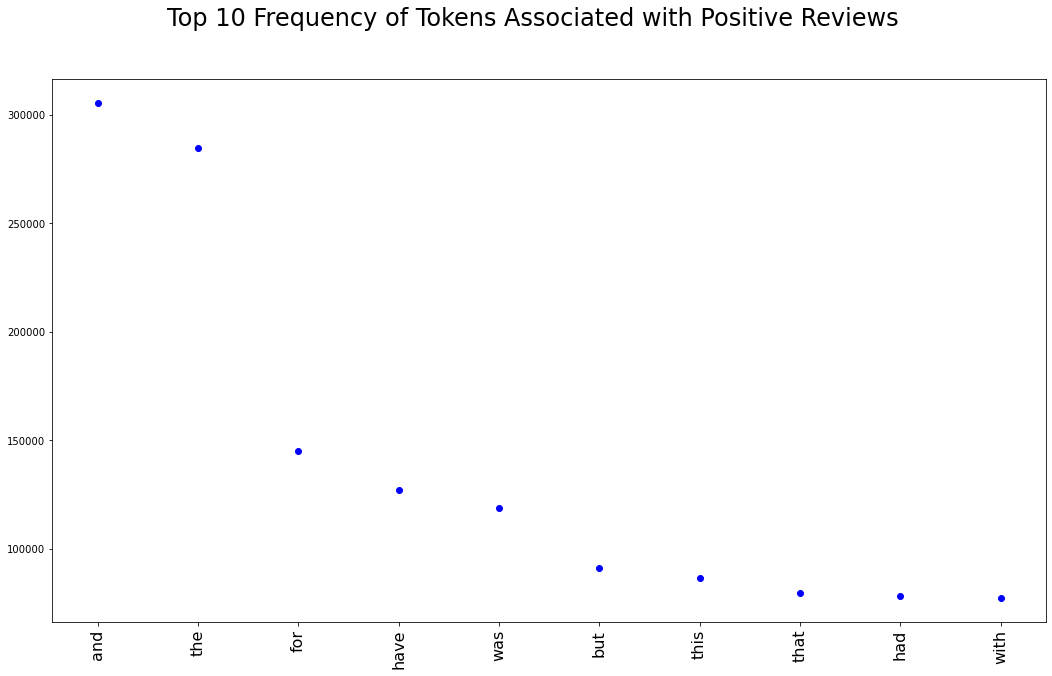

In [27]:
top_n = 10
term_freq_df_freq = term_freq_df_freq.head(10)
x = range(0, top_n)

fig, ax = plt.subplots(1, figsize = (17.8, 10))
fig.suptitle('Top 10 Frequency of Tokens Associated with Positive Reviews', fontsize= 24)

ax.plot(x, term_freq_df_freq["1 freq"], 'bo')
ax.set_xticks(x)
x_ticks_labels = term_freq_df_freq.index
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

plt.show()

### Convert the column of the review to a matrix of token counts using CountVectorizer and unigrams and bigrams.

In [28]:
count_vect = CountVectorizer(ngram_range=(1, 2))

matrix = count_vect.fit_transform(train['review'].values.astype('U'))

print(f'The size of the feature matrix for the texts = {matrix.get_shape()}')
print(f'The first ten mapping of token to index: {list(count_vect.vocabulary_.items())[:10]}')

The size of the feature matrix for the texts = (161297, 1335977)
The first ten mapping of token to index: [('has', 542332), ('side', 1017285), ('effect', 390769), ('take', 1109583), ('combination', 266786), ('bystolic', 224739), ('and', 103985), ('fish', 461375), ('oil', 814402), ('has side', 543852)]


### Perform the tf-idf analysis on the column of the review using Tfidfvectorizer.

In [29]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, sublinear_tf=False)
tf_idf_matrix = tfidf_vectorizer.fit_transform(train['review'].values.astype('U'))

print(f'The size of the tf_idf matrix for the texts = {tf_idf_matrix.get_shape()}')
print(f'The sparse tf_idf matrix is as follows:')
print(tf_idf_matrix)

The size of the tf_idf matrix for the texts = (161297, 49463)
The sparse tf_idf matrix is as follows:
  (0, 31425)	0.43471247204545377
  (0, 18803)	0.5245744518534793
  (0, 5308)	0.07620056157703906
  (0, 9147)	0.5050827541978907
  (0, 11313)	0.3729077641852149
  (0, 43317)	0.16579201270746616
  (0, 16269)	0.24575027329027177
  (0, 39994)	0.14962967166339416
  (0, 21482)	0.1600067792514513
  (1, 16274)	0.08468734575734846
  (1, 29371)	0.0760059202389398
  (1, 18233)	0.07202153119532721
  (1, 27897)	0.09383856597750784
  (1, 14480)	0.07963652261871237
  (1, 27501)	0.07707750893369464
  (1, 45268)	0.06628719054059587
  (1, 7665)	0.0617172034865849
  (1, 7382)	0.13665936874994472
  (1, 32102)	0.09107077303400359
  (1, 39884)	0.08900559640262609
  (1, 44086)	0.08172623780731583
  (1, 4753)	0.047498653966706744
  (1, 37274)	0.13963404881129576
  (1, 44085)	0.07598920353734039
  (1, 20646)	0.06331531896779423
  :	:
  (161296, 81)	0.11766120665774002
  (161296, 29258)	0.10537611925077747
  (1

### Find the cosine similarity in review between the 100th and 1,000th tweets.

In [30]:
two_reviews = [train['review'][100], train['review'][1000]]

two_reviews_matrix = tfidf_vectorizer.fit_transform(two_reviews)

cos_sim = cosine_similarity(two_reviews_matrix, dense_output=True)
print(f"The cosine similarity between")
print(two_reviews[0])
print("and")
print(two_reviews[1])
print(f" = {cos_sim[0,1]}")

The cosine similarity between
"Awful medicine, the worst. The side effects outweigh the benefit. Headache the first night, leg and back pain, Sensitive skin, just awful. Pain got worse and worse. changed meds ciproflaxcin. have used this the past hopefully, will continue help. even questioned the doc urgent care see can take cipro and she offered macrobid. Maybe this urgent care and this medication something they get deal ....stay away from macrobid."
and
" used Voltaren gel some sore joints (and tennis elbow). worked well anything have ever tried. sometimes get killer tension headaches that first build the back the neck. When felt one coming , used the gel the back the neck and shoulders. The headache never developed. Before this experiment would take 3 4 ibuprofen for one these headaches and hope for the best. The gel now standard treatment for these headaches."
 = 0.35124897060575394


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


### Build the first model based on the training dataset using the random forests and pipeline.

In [31]:
t0 = time()

X_train = train['review']
y_train = train['rating_binary']

tfidf_vector = TfidfVectorizer(ngram_range = (1,1))
classifier = LogisticRegression()
pipeline = Pipeline ([("vectorizer", tfidf_vector), ("classifier", classifier)])

pipeline.fit(X_train, y_train)

print(f"It takes about {time() - t0:.1f} seconds")

It takes about 18.4 seconds


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Check the first model on the test dataset. 

In [32]:
test['review'] = test['review'].apply(clean_text)
test['review'] = [lmtzr.lemmatize(word) for word in test['review']]
test['rating_binary'] = test['rating'].apply(ratings_convert)

X_test = test['review']
y_test = test['rating_binary']

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:309: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


Confusion matrix, without normalization
[[10883  5324]
 [ 2822 34737]]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:309: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


Normalized confusion matrix
[[0.67149997 0.32850003]
 [0.07513512 0.92486488]]


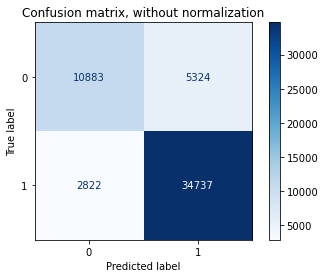

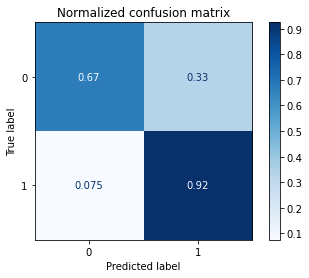

In [33]:
target_names = ['0', '1']
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(pipeline, X_test, y_test,
                                 display_labels= target_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [34]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

           0       0.79      0.67      0.73     16207
           1       0.87      0.92      0.90     37559

    accuracy                           0.85     53766
   macro avg       0.83      0.80      0.81     53766
weighted avg       0.85      0.85      0.84     53766



/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:309: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


### Create the second model using pipeline, grid search CV and SVC for the hyperparameters for the estimators. 

In [35]:
pipeline = Pipeline ([("vectorizer", TfidfVectorizer()),("classifier", DecisionTreeClassifier())])

parameters = {
    'vectorizer__max_df': (0.5, 1.0),
    'vectorizer__ngram_range': ((1, 1), (1,2)),
    'vectorizer__use_idf': (True, False),
    'classifier__max_features': ["auto"],
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("The pipeline contains:", [name for name, _ in pipeline.steps])
print("parameters are as follows:")
pprint(parameters)

t0 = time()
grid_search.fit(X_train, y_train)
print(f"It takes about {time() - t0:.1f} seconds.")
print()

print(f"Best score= {grid_search.best_score_:0.3f}")
print("Best parameters set:")

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name])) 

Performing grid search...
The pipeline contains: ['vectorizer', 'classifier']
parameters are as follows:
{'classifier__max_features': ['auto'],
 'vectorizer__max_df': (0.5, 1.0),
 'vectorizer__ngram_range': ((1, 1), (1, 2)),
 'vectorizer__use_idf': (True, False)}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 18.8min finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:844: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py:190: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `

It takes about 1246.9 seconds.

Best score= 0.838
Best parameters set:
	classifier__max_features: 'auto'
	vectorizer__max_df: 1.0
	vectorizer__ngram_range: (1, 2)
	vectorizer__use_idf: False


### Tune the second model and perform model diagnostics on the test dataset.

Confusion matrix, without normalization
[[12299  3908]
 [ 2831 34728]]
Normalized confusion matrix
[[0.75886962 0.24113038]
 [0.07537474 0.92462526]]


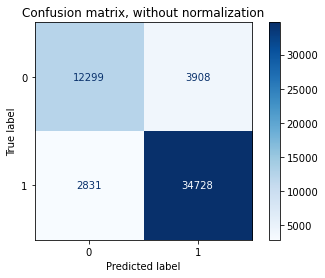

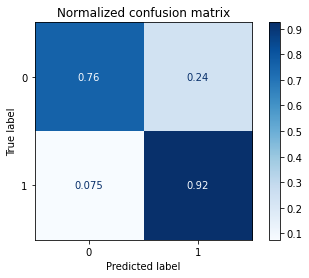

In [36]:
for title, normalize in titles_options:
    disp = plot_confusion_matrix(grid_search, X_test, y_test,
                                 display_labels= target_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [37]:
y_pred = grid_search.predict(X_test)

print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78     16207
           1       0.90      0.92      0.91     37559

    accuracy                           0.87     53766
   macro avg       0.86      0.84      0.85     53766
weighted avg       0.87      0.87      0.87     53766



### Generate the first topic model by setting five topics using LDA method and CountVectorizer on the review column.

In [38]:
tf_vectorizer = CountVectorizer(max_df=0.90, min_df=5, stop_words='english')
document_word_matrix_tf = tf_vectorizer.fit_transform(train['review'])

In [39]:
lda = LatentDirichletAllocation(n_components= 5 ,random_state= 101)
lda.fit(document_word_matrix_tf)

LatentDirichletAllocation(n_components=5, random_state=101)

### Plot the top 15 words for each topic for the model above.

In [40]:
n_top_words = 15 

for index,topic in enumerate(lda.components_):
    print(f'THE TOP {n_top_words} WORDS FOR TOPIC #{index}')
    print([tf_vectorizer.get_feature_names()[j] for j in topic.argsort()[-n_top_words:]])
    print('#'*150)

THE TOP 15 WORDS FOR TOPIC #0
['lost', 'days', 'time', 'weeks', 'week', 'medication', 'just', 'like', 'weight', 'effects', 'anxiety', 'started', 'feel', 'day', 'taking']
######################################################################################################################################################
THE TOP 15 WORDS FOR TOPIC #1
['like', 'time', 'sex', 'just', 'bleeding', 'periods', 'days', 'weight', 'got', 'month', 'birth', 'control', 'months', 'pill', 'period']
######################################################################################################################################################
THE TOP 15 WORDS FOR TOPIC #2
['weeks', 'medicine', 'started', 'life', 'days', 'drug', 'medication', 'months', 'blood', 'doctor', 'day', 'taking', 'effects', 'years', 'pain']
######################################################################################################################################################
THE TOP 15 WORDS FOR TOPIC #3
['did

In [41]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

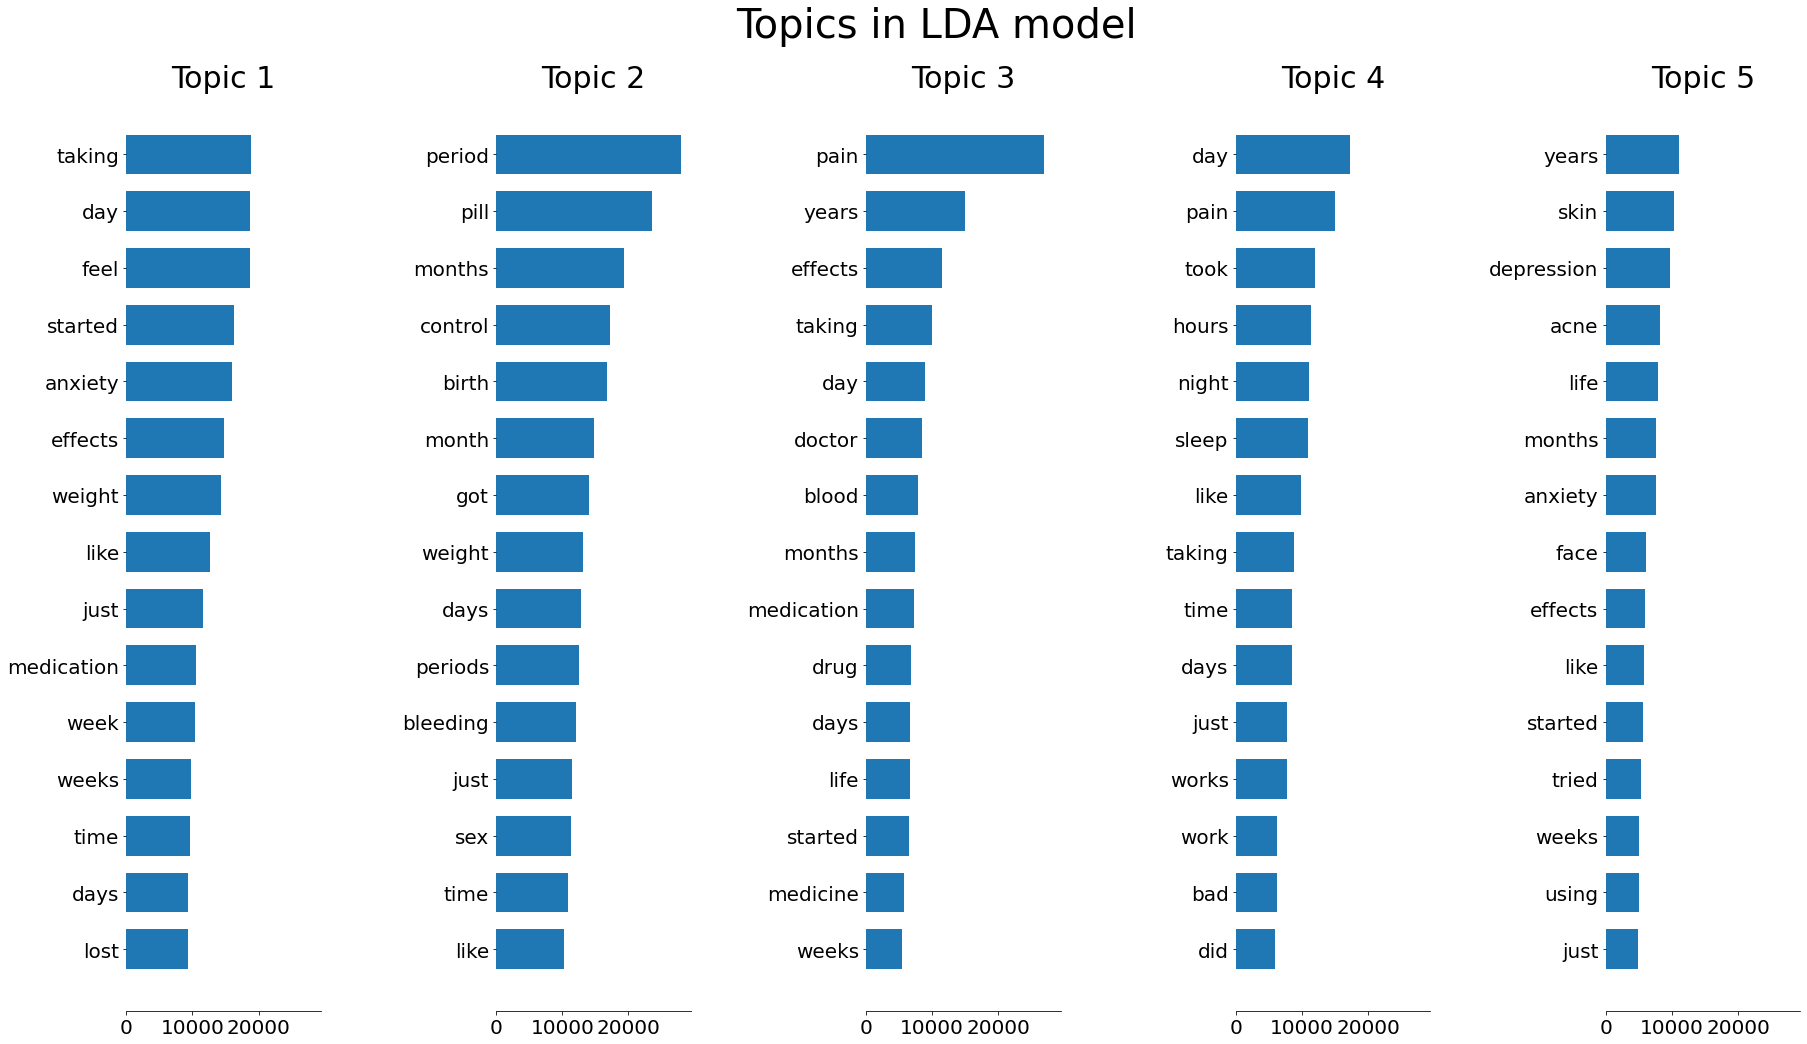

In [42]:
tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

### Generate the second topic model by setting five topics using LDA method and TfidfVectorizer on the review column.

In [43]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z0-9]{2,}\b', 
                                max_df = 0.9, 
                                min_df = 5)
document_word_matrix_tf_idf = tfidf_vectorizer.fit_transform(train['review'])

In [44]:
lda_tf_idf = LatentDirichletAllocation(n_components= 5, random_state= 101)
lda_tf_idf.fit(document_word_matrix_tf_idf)

LatentDirichletAllocation(n_components=5, random_state=101)

### Plot the top 15 words for each topic for the second model above.

In [45]:
n_top_words = 15 

for index,topic in enumerate(lda_tf_idf.components_):
    print(f'THE TOP {n_top_words} WORDS FOR TOPIC #{index}')
    print([tf_vectorizer.get_feature_names()[j] for j in topic.argsort()[-n_top_words:]])
    print('#'*150)

THE TOP 15 WORDS FOR TOPIC #0
['medicine', 'years', 'feel', 'good', 'medication', 'lbs', 'week', 'eat', 'pounds', 'effects', 'started', 'taking', 'day', 'lost', 'weight']
######################################################################################################################################################
THE TOP 15 WORDS FOR TOPIC #1
['mood', 'days', 'cramps', 'acne', 'sex', 'got', 'weight', 'month', 'bleeding', 'periods', 'months', 'control', 'birth', 'pill', 'period']
######################################################################################################################################################
THE TOP 15 WORDS FOR TOPIC #2
['day', 'taking', 'use', 'started', 'weeks', 'pressure', 'effects', 'face', 'months', 'using', 'pain', 'blood', 'acne', 'years', 'skin']
######################################################################################################################################################
THE TOP 15 WORDS FOR TOPIC #3
['work', '

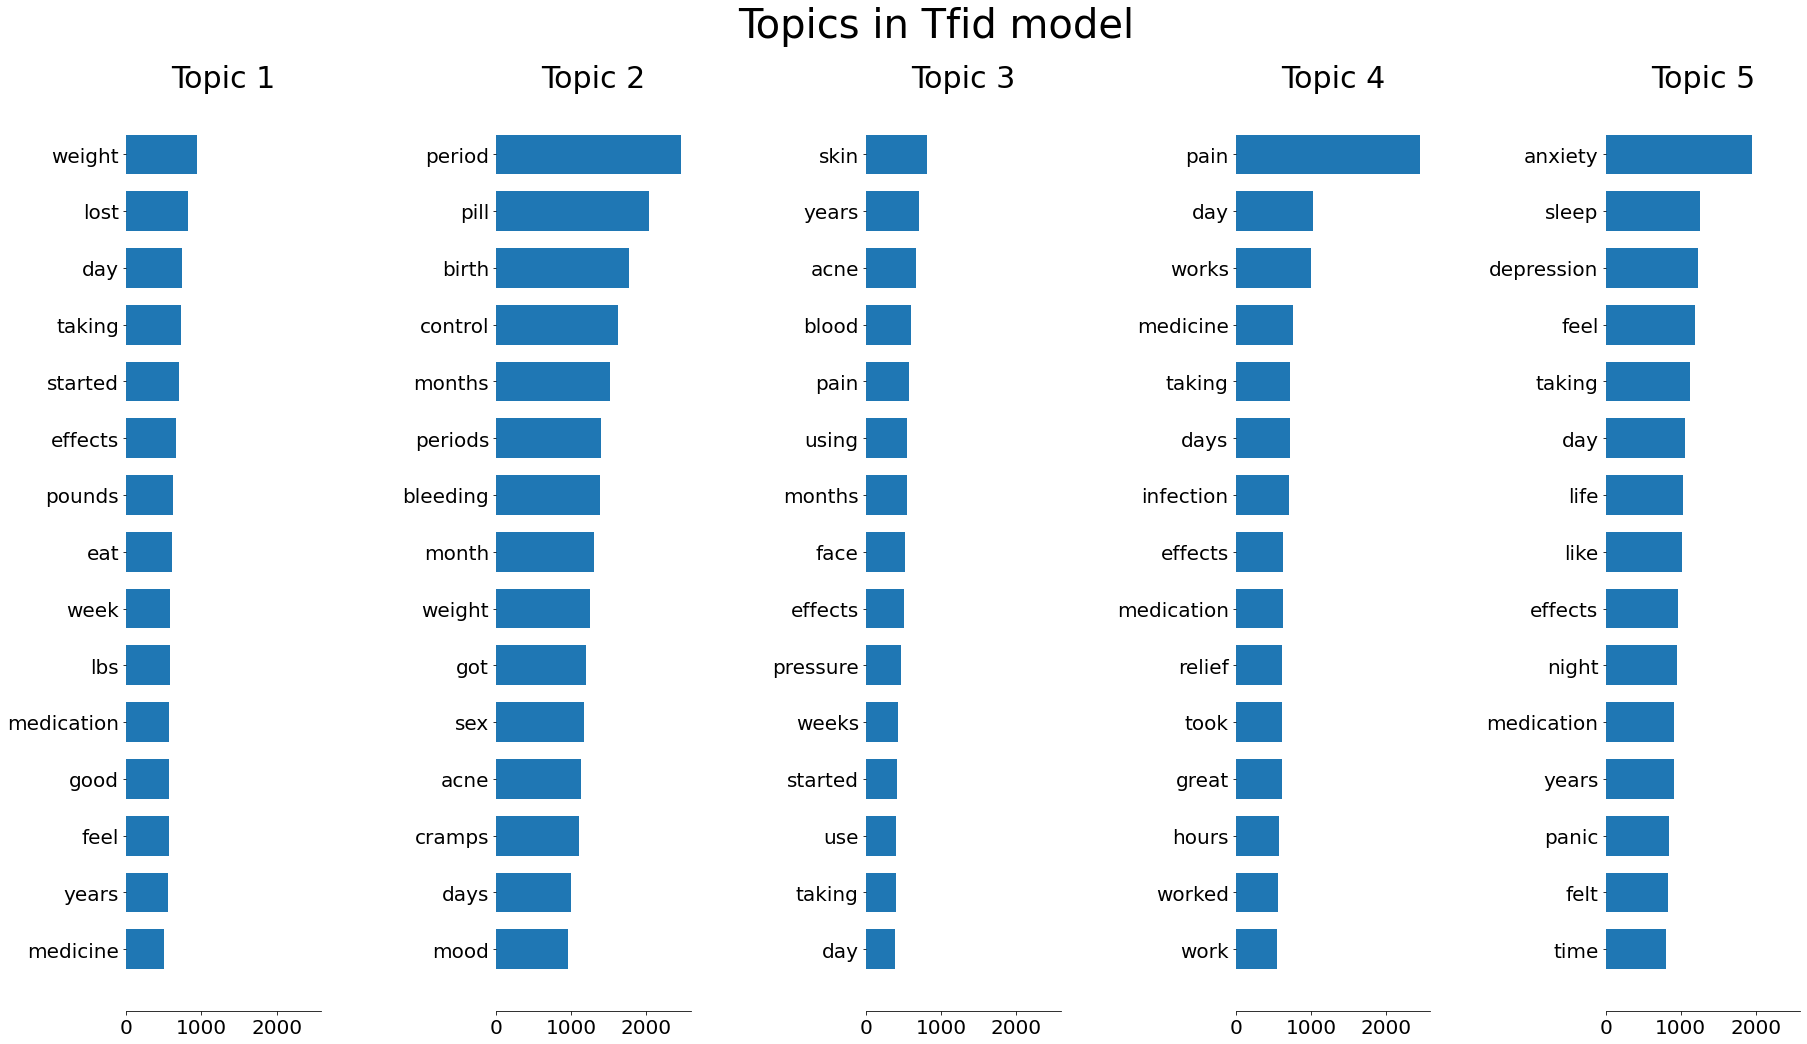

In [46]:
tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda_tf_idf, tf_feature_names, n_top_words, 'Topics in Tfid model')

### Visualize the second topic model using the dimension reduction method.

In [47]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model = lda_tf_idf, dtm = document_word_matrix_tf_idf, vectorizer = tfidf_vectorizer, mds='tsne')

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically want

PreparedData(topic_coordinates=           x       y  topics  cluster  Freq
topic                                      
4     150.22  -72.27       1        1 24.98
1      51.16 -159.97       2        1 23.69
3     -73.14   21.52       3        1 19.12
0     -66.41 -110.61       4        1 16.50
2      54.42   12.44       5        1 15.71, topic_info=           Term    Freq   Total Category  logprob  loglift
12326    period 2484.00 2484.00  Default    30.00    30.00
2828      birth 1702.00 1702.00  Default    29.00    29.00
12005      pain 3830.00 3830.00  Default    28.00    28.00
12329   periods 1356.00 1356.00  Default    27.00    27.00
2887   bleeding 1353.00 1353.00  Default    26.00    26.00
...         ...     ...     ...      ...      ...      ...
10552  medicine  329.46 2357.32   Topic5    -5.94    -0.12
5011       days  325.79 3006.05   Topic5    -5.95    -0.37
16863      time  321.12 2840.10   Topic5    -5.97    -0.33
10979     month  309.82 2282.17   Topic5    -6.00    -0.15
18183      went  294.90 1800.89   Topic5    -6.05     0.04

[447 rows x 6 columns], token_table=       Topic  Freq      Term
term                        
1286       3  0.99    abreva
1381       2  0.03  accutane
1381       5  0.96  accutane
1416       2  0.62      acne
1416       5  0.38      acne
...      ...   ...       ...
18546      4  0.01      zaps
18586      1  0.96    zoloft
18586      4  0.04    zoloft
18613      4  0.98     zyban
18619      3  0.99    zyrtec

[947 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 1, 3])